In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import imageio
import moviepy.editor as mp
import ffmpy

import os
from math import * 
os.getcwd()
print("The current directory is: ")
print(os.getcwd())
path_parent = os.path.dirname(os.getcwd())
if path_parent.endswith("Abaqus-Macromechanics-Project"):
    os.chdir(path_parent) 
    print("Moving up to the parent directory")
    print(os.getcwd())

The current directory is: 
c:\Users\springnuance\Desktop\Abaqus-Macromechanics-Project\notebooks
Moving up to the parent directory
c:\Users\springnuance\Desktop\Abaqus-Macromechanics-Project


In [5]:
from stage0_configs import *
from modules.SOO_SIM import *
from modules.IO import *
from modules.calculation import *
from optimizers.optimize import *
from modules.hardeningLaws import *
info = main_config()


loss_function = lossFD

info['targetPath'] = "MOO_targets/DP1000_25C_SwiftVoce_curve1"
info['resultPath'] = "MOO_results/DP1000_25C_SwiftVoce_curve1"
geometries = ["NDBR50","NDBR20","NDBR6","CHD6","SH"]


Welcome to Abaqus hardening parameter calibration project


The configurations you have chosen: 

+------------------------+-----------------------------+
|     Global Configs     |         User choice         |
+------------------------+-----------------------------+
|    SLURM iteration     |        one_node_small       |
| Number of initial sims |             200             |
|   Optimize strategy    |             MOO             |
|        Material        |          DP1000_25C         |
|     Hardening law      |          SwiftVoce          |
|      Curve index       |              1              |
|       Geometries       | NDBR50,NDBR20,NDBR6,CHD6,SH |
|     Optimizer name     |           BOTORCH           |
|   Deviation percent    |              2              |
+------------------------+-----------------------------+

Generating necessary directories

The path to your main project folder is

c:\Users\springnuance\Desktop\Abaqus-Macromechanics-Project



# Iteration guess FD curve simulations

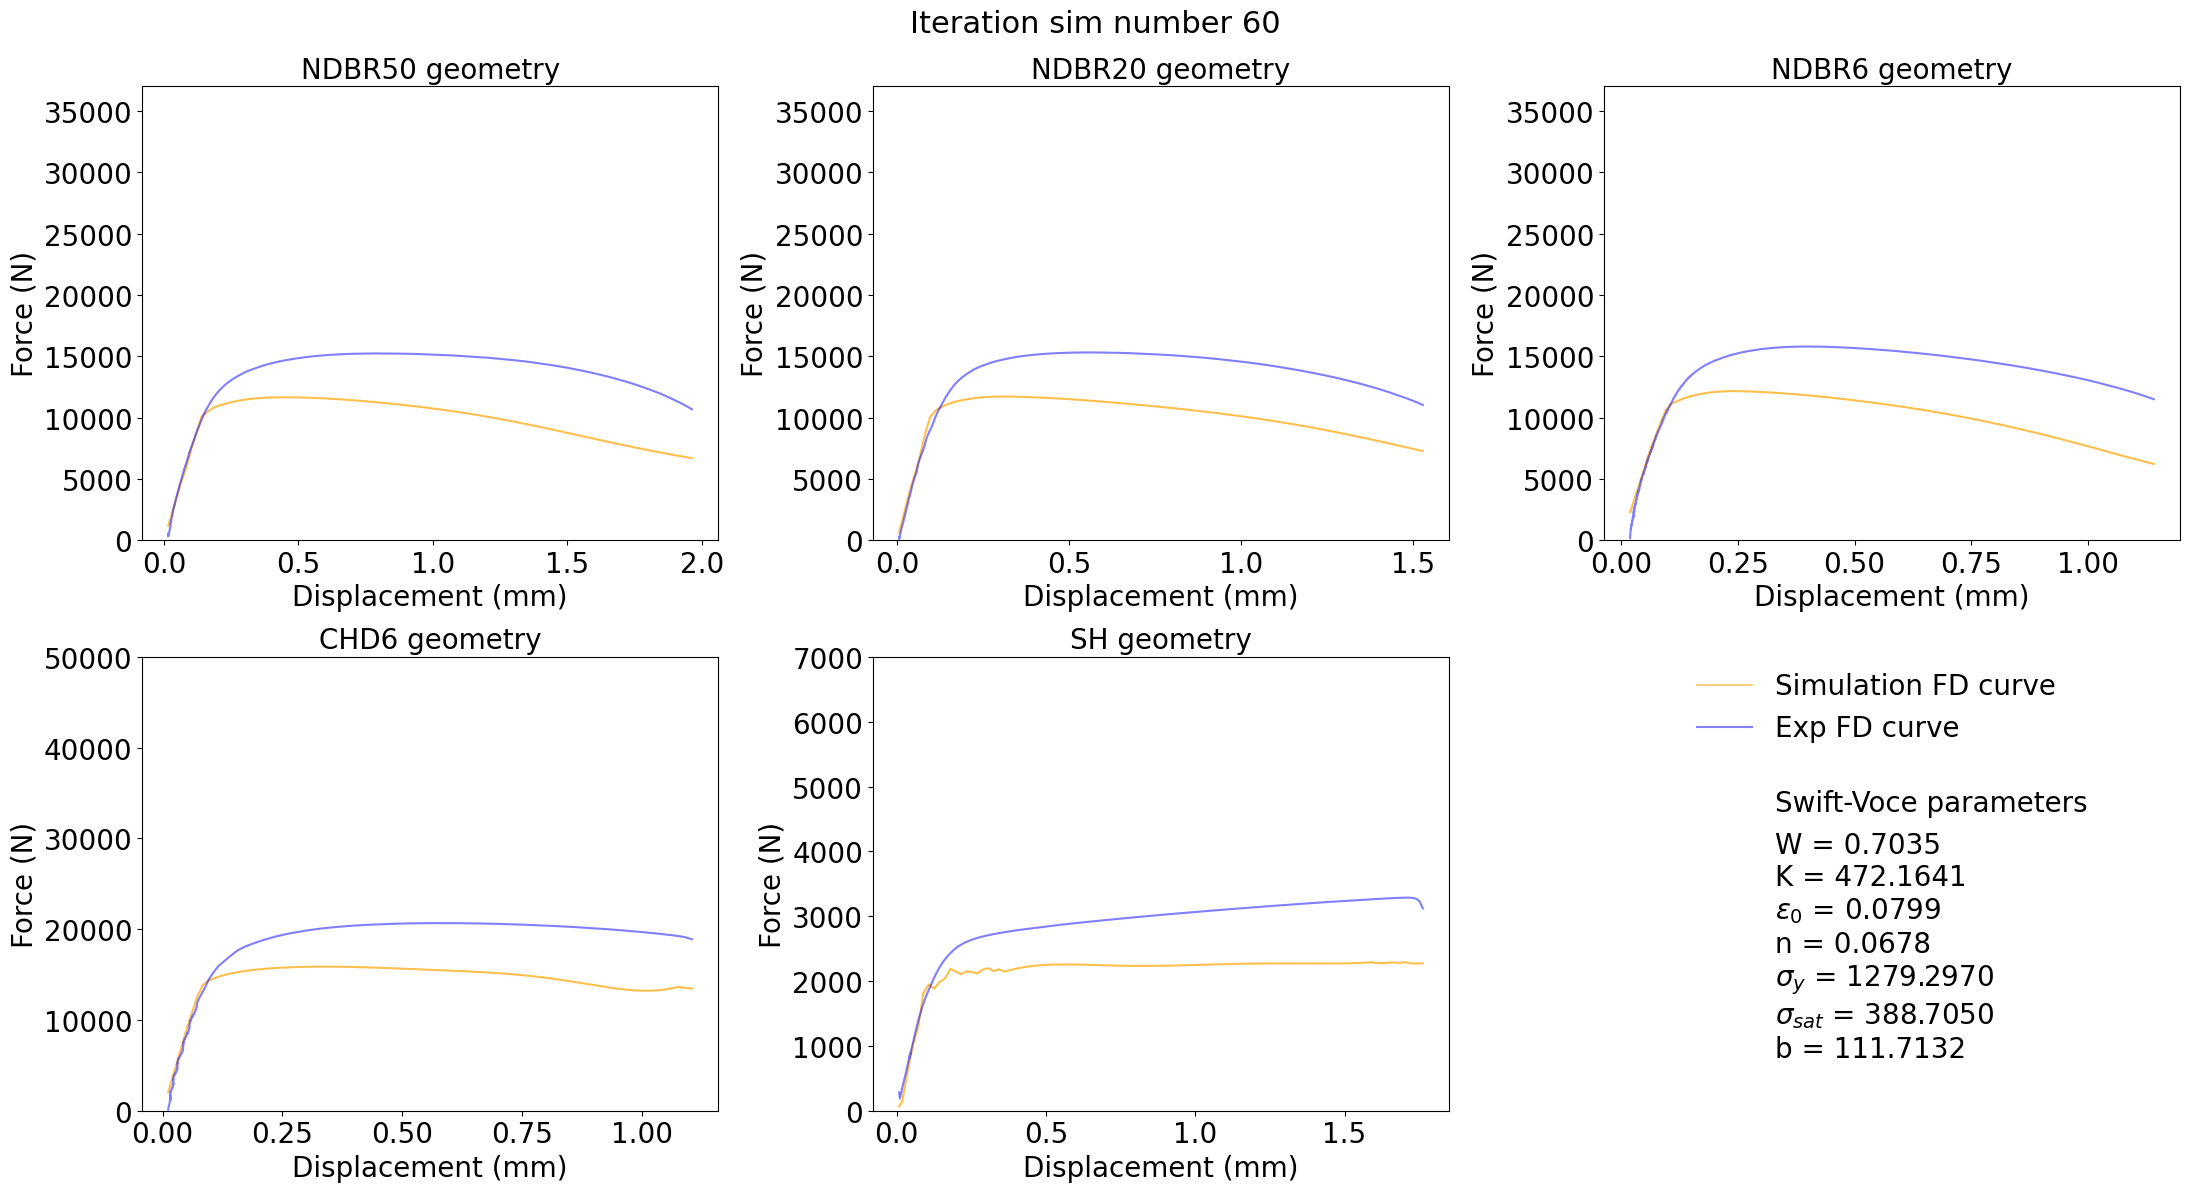

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

resultPath = info['resultPath']
targetPath = info['targetPath']

def interpolating_FD_Curves(FD_Curves, targetCurve):
    # Interpolate the force from FD_Curves to the target curve
    # FD_Curves is a dictionaries
    # where each element is of form (parameterTuples) => {"displacement": <np.array>, "force": <np.array>}
    # targetCurve is a dictionary of form {"displacement": <np.array>, "force": <np.array>}

    # Create interp1d fitting from scipy
    FD_Curves_copy = copy.deepcopy(FD_Curves)
    for paramsTuple, dispforce in FD_Curves_copy.items():
        simDisp = dispforce["displacement"]
        simForce = dispforce["force"]
        targetDisp = targetCurve["displacement"]
        # Interpolate the force
        FD_Curves_copy[paramsTuple]["force"] = interpolatingForce(simDisp, simForce, targetDisp)
        FD_Curves_copy[paramsTuple]["displacement"] = targetDisp
    return FD_Curves_copy

def format_params(params):
    string_params = ""
    for param in params:
        string_params += f"{SwiftVoce_mapping[param[0]]} = {param[1]:.4f}\n"
    return string_params

SwiftVoce_mapping = {
    "c1": "W",
    "c2": "K",
    "c3": r"$\epsilon_0$",
    "c4": "n",
    "c5": r"$\sigma_y$",
    "c6": r"$\sigma_{sat}$",
    "c7": "b",
}


def plot_iteration_FD(iter, animation=False):
    
    geometries_grid = {
        "NDBR50": (0,0),
        "NDBR20": (0,1),
        "NDBR6": (0,2),
        "CHD6": (1,0),
        "SH": (1,1),
    }

    ylim = {
        "NDBR50": (0, 37000),
        "NDBR20": (0, 37000),
        "NDBR6": (0, 37000),
        "CHD6": (0, 50000),
        "SH": (0, 7000),
    }

    # Create a figure and axes with the grid layout
    fig, axs = plt.subplots(2, 3, figsize=(22, 12))  # Adjust the size as needed

    fontsize = 20

    fig.suptitle(f'Iteration sim number {iter}', fontsize=fontsize+2, y=0.99)

    
    params = None
    for geometry, position in geometries_grid.items():
        ax = axs[position]  # Get the correct axis for the current geometry

        # Read data for the current geometry
        expCurve = pd.read_csv(f"{targetPath}/{geometry}/FD_Curve.csv")
        expDisplacement = expCurve['displacement/mm'].to_numpy()
        expForce = expCurve['force/N'].to_numpy()

        targetCurve = {}
        targetCurve['displacement'] = expDisplacement
        targetCurve['force'] = expForce

        # Load iteration data
        iteration_original_FD_Curves = np.load(f"{resultPath}/{geometry}/iteration/common/FD_Curves_smooth.npy", allow_pickle=True).tolist()
        #print(iteration_original_FD_Curves)
        iteration_interpolated_FD_Curves = interpolating_FD_Curves(iteration_original_FD_Curves, targetCurve)
        
        # Plotting all iterations
        # for param in iteration_original_FD_Curves:
        #     ax.plot(iteration_original_FD_Curves[param]['displacement'], 
        #             iteration_original_FD_Curves[param]['force'], 
        #             color='orange', 
        #             alpha=0.3)
        
        # Plot the last iteration with a thicker line
        last_iteration = list(iteration_interpolated_FD_Curves.items())[iter - 1]
        params = last_iteration[0]
        ax.plot(last_iteration[1]['displacement'],
                last_iteration[1]['force'],
                color='orange',
                alpha=0.7)

        # Plot target curve
        ax.plot(expDisplacement, expForce, label='Target FD curve', color='blue', alpha=0.5)

        # Set titles, labels, and legends for each subplot
        ax.set_title(f'{geometry} geometry', fontsize=fontsize)
        ax.set_xlabel('Displacement (mm)', fontsize=fontsize)
        ax.set_ylabel('Force (N)', fontsize=fontsize)
        ax.set_ylim(ylim[geometry])
        ax.tick_params(labelsize=fontsize)
        

    ax = axs[1,2]
    ax.axis('off')
    ax.plot([], [], color='orange', alpha=0.5, label=f'Simulation FD curve')
    ax.plot([], [], color='blue', alpha=0.5, label=f'Exp FD curve')
    ax.plot([], [], color='white', label=f'\nSwift-Voce parameters')
    ax.plot([], [], color='white', label=f'{format_params(params)}')
    ax.legend(fontsize=fontsize, loc='center', frameon=False)
    
    if animation:

        plt.tight_layout()
        fig.savefig(f"notebooks/DP1000_20C_5geoms_FD_Curve/iter_{iter}.png")  # Save the figure
        plt.close(fig)  # Close the figure to free memory
    else:
        plt.tight_layout()
        plt.show()

plot_iteration_FD(60) # Test from 1 to 60

In [67]:
import imageio

for i in range(1, 61):  # Assuming you want to generate 60 iterations
    plot_iteration_FD(i, animation=True)

images = []
for i in range(1, 40): # it looks like iter 39 is the best
    filename = f"notebooks/DP1000_20C_5geoms_FD_Curve/iter_{i}.png"
    images.append(imageio.imread(filename))

imageio.mimsave(f"notebooks/DP1000_20C_5geoms_FD_Curve/animation.gif", images, duration=500)  # Adjust fps as needed


# Iteration guess flow curve simulations

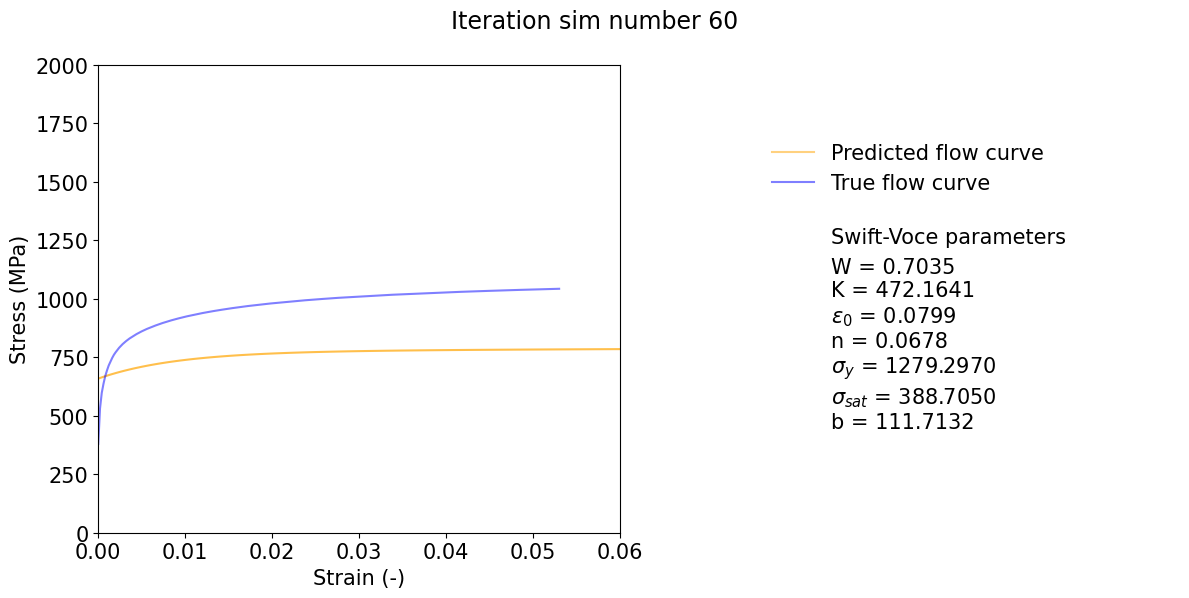

In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

resultPath = info['resultPath']
targetPath = info['targetPath']

def format_params(params):
    string_params = ""
    for param in params:
        string_params += f"{SwiftVoce_mapping[param[0]]} = {param[1]:.4f}\n"
    return string_params

SwiftVoce_mapping = {
    "c1": "W",
    "c2": "K",
    "c3": r"$\epsilon_0$",
    "c4": "n",
    "c5": r"$\sigma_y$",
    "c6": r"$\sigma_{sat}$",
    "c7": "b",
}


def plot_iteration_flow(iter, animation=False):
    
    # Create a figure and axes with the grid layout
  
    fontsize = 15

    
    params = None

    # Create a figure and axes with the grid layout
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # Adjust the size as needed

    fig.suptitle(f'Iteration sim number {iter}', fontsize=fontsize+2, y=0.99)

    # Read data for the current geometry
    expCurve = pd.read_csv(f"{targetPath}/flowCurve.csv")
    expStrain = expCurve['strain/-'].to_numpy()
    expStress = expCurve['stress/MPa'].to_numpy()

    # Load iteration data
    flowCurves = np.load(f"{resultPath}/{geometry}/iteration/common/flowCurves.npy", allow_pickle=True).tolist()
    
    ax = axs[0]
    # Plot the last iteration with a thicker line
    last_iteration = list(flowCurves.items())[iter - 1]
    params = last_iteration[0]
    ax.plot(last_iteration[1]['strain'],
            last_iteration[1]['stress'],
            color='orange',
            alpha=0.7)

    # Plot target curve
    ax.plot(expStrain, expStress, label='Target flow curve', color='blue', alpha=0.5)
    
    # Set titles, labels, and legends for each subplot
    #ax.set_title(f'{geometry} geometry', fontsize=fontsize)
    ax.set_xlabel('Strain (-)', fontsize=fontsize)
    ax.set_ylabel('Stress (MPa)', fontsize=fontsize)
    ax.set_ylim([0, 2000])
    ax.set_xlim([0, 0.06])
    ax.tick_params(labelsize=fontsize)
        

    ax = axs[1]
    ax.axis('off')
    ax.plot([], [], color='orange', alpha=0.5, label=f'Predicted flow curve')
    ax.plot([], [], color='blue', alpha=0.5, label=f'True flow curve')
    ax.plot([], [], color='white', label=f'\nSwift-Voce parameters')
    ax.plot([], [], color='white', label=f'{format_params(params)}')
    ax.legend(fontsize=fontsize, loc='center', frameon=False)
    
    if animation:

        plt.tight_layout()
        fig.savefig(f"notebooks/DP1000_20C_5geoms_flowCurve/iter_{iter}.png")  # Save the figure
        plt.close(fig)  # Close the figure to free memory
    else:
        plt.tight_layout()
        plt.show()

plot_iteration_flow(60) # Test from 1 to 60

In [ ]:
import imageio

for i in range(1, 61):  # Assuming you want to generate 60 iterations
    plot_iteration_flow(i, animation=True)

images = []
for i in range(1, 40): # it looks like iter 39 is the best
    filename = f"notebooks/DP1000_20C_5geoms_flowCurve/iter_{i}.png"
    images.append(imageio.imread(filename))

imageio.mimsave(f"notebooks/DP1000_20C_5geoms_flowCurve/animation.gif", images, duration=500)  # Adjust fps as needed